In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
# !ls
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install spark_sklearn

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [5]:
#import library

import time
from scipy import stats
import pyspark
from pyspark import SparkContext, SparkConf
sc = pyspark.SparkContext()
import os
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
training = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/training/trainingSet_noEmpty.csv")
testing = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/testing/testingSet_noEmpty.csv")

print(training.shape)
print(training.columns)
print()
print(testing.shape)
print(testing.columns)

(2690, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)

(1140, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)


In [0]:
# Reorder the column in test set so that columns order in both training and testing set can remain consistent
testing = testing[training.columns.values]

In [0]:
# convert back those attribute to int

training[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']] = training[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']].astype(int)

testing[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']] = testing[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']].astype(int)

In [0]:
training.iloc[:,65:122] = training.iloc[:,65:122].astype(int)
testing.iloc[:,65:122] = testing.iloc[:,65:122].astype(int)

In [0]:
training['FTR'] = training['FTR'].map({'A':0,'D':1,'H':2})
testing['FTR'] = testing['FTR'].map({'A':0,'D':1,'H':2})

In [0]:
training.rename(columns={"BbMx<2.5": "BbMx_less_than_2.5", "BbAv<2.5": "BbAv_less_than_2.5", "BbMx>2.5": "BbMx_more_than_2.5", "BbAv>2.5": "BbAv_more_than_2.5"},inplace = True)
testing.rename(columns={"BbMx<2.5": "BbMx_less_than_2.5", "BbAv<2.5": "BbAv_less_than_2.5", "BbMx>2.5": "BbMx_more_than_2.5", "BbAv>2.5": "BbAv_more_than_2.5"},inplace = True)

In [12]:
training.iloc[:,49:53].columns.values

array(['BbMx_more_than_2.5', 'BbAv_more_than_2.5', 'BbMx_less_than_2.5',
       'BbAv_less_than_2.5'], dtype=object)

In [13]:
testing.iloc[:,49:53].columns.values

array(['BbMx_more_than_2.5', 'BbAv_more_than_2.5', 'BbMx_less_than_2.5',
       'BbAv_less_than_2.5'], dtype=object)

In [14]:
print(training.shape)
print(testing.shape)

(2690, 123)
(1140, 123)


In [0]:
# Wrapper Approach - Recursive Feature Elinmination
# feature important score - feature selection
# http://danielhomola.com/2015/05/08/borutapy-an-all-relevant-feature-selection-method/
# https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/
# https://www.kaggle.com/rsmits/feature-selection-with-boruta

In [16]:
!pip install boruta

     |████████████████████████████████| 61kB 2.6MB/s 


In [0]:
import pandas
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [0]:
X_train = training.drop('FTHG',axis = 1)
y_train = training['FTHG']

X_test = training.drop('FTHG',axis = 1)
y_test = training['FTHG']

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2)

# find all relevant features
feat_selector.fit(X_train.values, y_train.values)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	118
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	118
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	118
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	118
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	118
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	118
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	118
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	118
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	2


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=24, n_jobs=-1, oob_score=False,
            random_state=RandomState(MT19937) at 0x7F0E579ECA98, verbose=0,
            warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=RandomState(MT19937) at 0x7F0E579ECA98, two_step=True,
     verbose=2)

In [21]:
# check selected features
feat_selector.support_

array([False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [22]:
# check ranking of features
feat_selector.ranking_

array([120,  58,  59,  43,  35,   1,  56,   5,  48,   1,  53,  14,  50,
        45,  54,  62,  60,  73,  65,  25,  52,  26,  13,  38,  10,   8,
        32,  12,   1,  57,  49,  41,  51,  46,  15,  40,   6,  23,  42,
        37,  44,   9,  15,   3,  23,  29,  21,  39,  17,  19,  30,  34,
        46,  54,  18,  30,  32,  36,  28,  19,   4,  11,   7,  26, 115,
       109,  91,  74,  64, 101,  87, 105, 117,  97,  91, 118, 104,  95,
        80, 111, 100,  90, 103,  66,  75,  93, 105,  87,  72,  77,  83,
       114,  70,  81,  97, 111,  83,  96, 107, 115,  83,  79, 118,  63,
        76, 110, 113,  94,  71,  68,  86,  85,  78,  99, 101, 107,  69,
        89,  67,  61,  21,   2])

In [23]:
features = X_train.columns
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print(final_features)
print("Number of selected features: ", len(final_features))

['HTHG', 'HST', 'LBH']
Number of selected features:  3


In [24]:
#newXtrain = X_train[['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HST', 'AST', 'SJH', 'BbAvH', 'BbAvA', 'PSH', 'PSA', 'PSCH', 'PSCA', 'HTR_A', 'HTR_D', 'HTR_H']]
newXtrain = X_train[final_features]
newXtrain.shape

(2690, 3)

In [25]:
#newXtest = X_test[['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HST', 'AST', 'SJH', 'BbAvH', 'BbAvA', 'PSH', 'PSA', 'PSCH', 'PSCA', 'HTR_A', 'HTR_D', 'HTR_H']]
newXtest = X_test[final_features]
newXtest.shape

(2690, 3)

In [0]:
import time
from sklearn.ensemble import RandomForestClassifier
import spark_sklearn
from spark_sklearn import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,roc_curve,auc

In [0]:
def metrics_calculation(model_name,Y_true,Y_predict):
  #roc=roc_auc_score(Y_true, Y_predict)
  accuracy = accuracy_score(Y_true, Y_predict)
  precision = precision_score(Y_true, Y_predict,average=None)
  recall = recall_score(Y_true, Y_predict,average=None)
  f1 = f1_score(Y_true, Y_predict,average=None)
  metrics=  pd.DataFrame([[model_name,accuracy,precision,recall,f1]],columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
  return metrics

In [0]:
model_results = []
models = {}
confusion_matrices = []
time_results=[]

In [0]:
# Random Forest Classifier
parameters = {
    "max_depth": [3, None],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

In [30]:
start = time.time()
gs = spark_sklearn.GridSearchCV(sc,estimator=RandomForestClassifier(), cv=5,param_grid=parameters,n_jobs=-1)
gs.fit(newXtrain, y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("RandomForestClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 5.869392156600952 seconds


[('RandomForestClassifier', 5.869392156600952)]

In [31]:
models['rfc'] = gs
predYtest = gs.predict(newXtest)
model_results.append(metrics_calculation('Random Forest Classifier',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
 
 [1 rows x 5 columns]]

In [32]:
# confusion matrix

#confusion_matrices.append(confusion_matrix(Y_test,predYtest))
#confusion_matrices
print('Random Forest: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("RandomForestClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

Random Forest:  [[402 181   0   0   0   0   0   0   0   0]
 [206 559  95   0   0   0   0   0   0   0]
 [ 64 343 247   5   2   0   0   0   0   0]
 [  4 120 195  13   7   0   0   0   0   0]
 [  0  14 111  21  13   0   0   0   0   0]
 [  0   3  31   4  23   0   0   0   0   0]
 [  0   0   5   1  12   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0]
 [  0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[402, 181,   0,   0,   0,   0,   0,   0,   0,   0],
         [206, 559,  95,   0,   0,   0,   0,   0,   0,   0],
         [ 64, 343, 247,   5,   2,   0,   0,   0,   0,   0],
         [  4, 120, 195,  13,   7,   0,   0,   0,   0,   0],
         [  0,  14, 111,  21,  13,   0,   0,   0,   0,   0],
         [  0,   3,  31,   4,  23,   0,   0,   0,   0,   0],
         [  0,   0,   5,   1,  12,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0]]))]

In [0]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
parameters = {
    'max_depth':[2,4,6,8,10],
    'min_samples_leaf':[2,4,6,8,10], 
    'min_samples_split':[2,4,6,8,10],
    'criterion': ['gini','entropy']
}

In [34]:
start = time.time()
dt = DecisionTreeClassifier()
gs_dt = spark_sklearn.GridSearchCV(sc,estimator=dt,cv=5,param_grid=parameters,n_jobs=-1)
gs_dt.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("DecisionTreeClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 48.00357484817505 seconds


[('RandomForestClassifier', 5.869392156600952),
 ('DecisionTreeClassifier', 48.00357484817505)]

In [35]:
models['dt'] = gs_dt
predYtest = gs_dt.predict(newXtest)
model_results.append(metrics_calculation('Decision Tree',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.6565934065934066, 0.5331846068042387, 0.427...
 
 [1 rows x 5 columns]]

In [36]:
# confusion matrix
print('Decision Tree: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("DecisionTreeClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

Decision Tree:  [[478  93  11   1   0   0   0   0   0   0]
 [280 478  99   2   0   1   0   0   0   0]
 [ 98 251 256  45   7   4   0   0   0   0]
 [ 13  93 112  99  19   3   0   0   0   0]
 [  3  17  48  47  33  11   0   0   0   0]
 [  1   1  12  13  10  24   0   0   0   0]
 [  0   0   0   1   8   9   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0]]


[('RandomForestClassifier',
  array([[402, 181,   0,   0,   0,   0,   0,   0,   0,   0],
         [206, 559,  95,   0,   0,   0,   0,   0,   0,   0],
         [ 64, 343, 247,   5,   2,   0,   0,   0,   0,   0],
         [  4, 120, 195,  13,   7,   0,   0,   0,   0,   0],
         [  0,  14, 111,  21,  13,   0,   0,   0,   0,   0],
         [  0,   3,  31,   4,  23,   0,   0,   0,   0,   0],
         [  0,   0,   5,   1,  12,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[478,  93,  11,   1,   0,   0,   0,   0,   0,   0],
         [280, 478,  99,   2,   0,   1,   0,   0,   0,   0],
         [ 98, 251, 256,  45,   7,   4,   0,   0,   0,   0],
         [ 13,  93, 112,  99,  19,   3,   0,   0,   0,   0],
         [  3,  17,  48,  47,  33,  11,   0,   0,   0,   0],
         [  1,   1,  12,  

In [0]:
# KNN Classifier
parameters = {
    'n_neighbors': [3,5,10],
}

In [38]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
knn = KNeighborsClassifier()
gs_knn = spark_sklearn.GridSearchCV(sc,estimator=knn,cv=5,param_grid=parameters,n_jobs=-1)
gs_knn.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("KNeighborsClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 1.667417049407959 seconds


[('RandomForestClassifier', 5.869392156600952),
 ('DecisionTreeClassifier', 48.00357484817505),
 ('KNeighborsClassifier', 1.667417049407959)]

In [39]:
models['knn'] = gs_knn
predYtest = gs_knn.predict(newXtest)
model_results.append(metrics_calculation('KNN Classifier',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.6565934065934066, 0.5331846068042387, 0.427...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6779411764705883, 0.5831032578685809, 0.476...
 
 [1 rows x 5 columns]]

In [40]:
# confusion matrix
print('KNN Classifier: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

KNN Classifier:  [[461  98  22   2   0   0   0   0   0   0]
 [216 528  98  15   3   0   0   0   0   0]
 [ 85 222 301  42   9   2   0   0   0   0]
 [ 12  82 111 112  20   2   0   0   0   0]
 [  2  18  52  42  39   5   1   0   0   0]
 [  1   3  17  15  11  12   2   0   0   0]
 [  0   0   1   2   6   8   1   0   0   0]
 [  0   0   0   0   2   3   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0]]


[('RandomForestClassifier',
  array([[402, 181,   0,   0,   0,   0,   0,   0,   0,   0],
         [206, 559,  95,   0,   0,   0,   0,   0,   0,   0],
         [ 64, 343, 247,   5,   2,   0,   0,   0,   0,   0],
         [  4, 120, 195,  13,   7,   0,   0,   0,   0,   0],
         [  0,  14, 111,  21,  13,   0,   0,   0,   0,   0],
         [  0,   3,  31,   4,  23,   0,   0,   0,   0,   0],
         [  0,   0,   5,   1,  12,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[478,  93,  11,   1,   0,   0,   0,   0,   0,   0],
         [280, 478,  99,   2,   0,   1,   0,   0,   0,   0],
         [ 98, 251, 256,  45,   7,   4,   0,   0,   0,   0],
         [ 13,  93, 112,  99,  19,   3,   0,   0,   0,   0],
         [  3,  17,  48,  47,  33,  11,   0,   0,   0,   0],
         [  1,   1,  12,  

In [0]:
# Logistic Regression
parameters = {
  'C': [0.001, 0.01, 0.1, 1, 10], 
  'class_weight': [None, 'balanced'], 
  'penalty': ['l1', 'l2']
}

In [42]:
from sklearn.linear_model import LogisticRegression
start = time.time()
lr = LogisticRegression()
gs_lr = spark_sklearn.GridSearchCV(sc,estimator=lr,param_grid = parameters,cv=5,n_jobs=-1)
gs_lr.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("LogisticRegression",finish - start))
time_results

Time required to do Parallel Grid Search CV: 8.429654121398926 seconds


[('RandomForestClassifier', 5.869392156600952),
 ('DecisionTreeClassifier', 48.00357484817505),
 ('KNeighborsClassifier', 1.667417049407959),
 ('LogisticRegression', 8.429654121398926)]

In [43]:
models['lr'] = gs_lr
predYtest = gs_lr.predict(newXtest)
model_results.append(metrics_calculation('Logistic Regression',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.6565934065934066, 0.5331846068042387, 0.427...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6779411764705883, 0.5831032578685809, 0.476...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.640176600441501, 0.5264797507788161, 0.3962...
 
 [1 rows x 5 columns]]

In [44]:
# Confusion Matrix
print('Logistic Regression: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("LogisticRegression",confusion_matrix(y_test,predYtest)))
confusion_matrices

Logistic Regression:  [[435 146   2   0   0   0   0   0   0   0]
 [255 507  98   0   0   0   0   0   0   0]
 [ 79 302 277   1   2   0   0   0   0   0]
 [  7 100 209  19   4   0   0   0   0   0]
 [  0   9 119  28   3   0   0   0   0   0]
 [  0   2  29  18  12   0   0   0   0   0]
 [  0   0   3   7   8   0   0   0   0   0]
 [  0   0   0   4   1   0   0   0   0   0]
 [  0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[402, 181,   0,   0,   0,   0,   0,   0,   0,   0],
         [206, 559,  95,   0,   0,   0,   0,   0,   0,   0],
         [ 64, 343, 247,   5,   2,   0,   0,   0,   0,   0],
         [  4, 120, 195,  13,   7,   0,   0,   0,   0,   0],
         [  0,  14, 111,  21,  13,   0,   0,   0,   0,   0],
         [  0,   3,  31,   4,  23,   0,   0,   0,   0,   0],
         [  0,   0,   5,   1,  12,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[478,  93,  11,   1,   0,   0,   0,   0,   0,   0],
         [280, 478,  99,   2,   0,   1,   0,   0,   0,   0],
         [ 98, 251, 256,  45,   7,   4,   0,   0,   0,   0],
         [ 13,  93, 112,  99,  19,   3,   0,   0,   0,   0],
         [  3,  17,  48,  47,  33,  11,   0,   0,   0,   0],
         [  1,   1,  12,  

In [0]:
# SGD
parameters = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 
  'class_weight': [None, 'balanced']
}

In [46]:
from sklearn.linear_model import SGDClassifier
start = time.time()
sgd = SGDClassifier(loss="hinge")
gs_sgd = spark_sklearn.GridSearchCV(sc,estimator=sgd,param_grid = parameters,cv=5,n_jobs=-1)
gs_sgd.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("SGD Classifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 2.5563430786132812 seconds


[('RandomForestClassifier', 5.869392156600952),
 ('DecisionTreeClassifier', 48.00357484817505),
 ('KNeighborsClassifier', 1.667417049407959),
 ('LogisticRegression', 8.429654121398926),
 ('SGD Classifier', 2.5563430786132812)]

In [47]:
models['sgd'] = gs_sgd
predYtest = gs_sgd.predict(newXtest)
model_results.append(metrics_calculation('SGD',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.6565934065934066, 0.5331846068042387, 0.427...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6779411764705883, 0.5831032578685809, 0.476...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.640176600441501, 0.5264797507788161, 0.3962...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5992990654205607, 0.36613475177304966, 0.0,...
 
 [1 rows x 5 columns]]

In [48]:
# Confusion Matrix
print('SGD: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("SGDClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

SGD:  [[513  70   0   0   0   0   0   0   0   0]
 [445 413   0   1   0   0   0   0   1   0]
 [149 496   0  12   0   1   0   0   3   0]
 [ 22 275   0  39   0   2   0   0   1   0]
 [  0 109   0  47   0   2   0   0   1   0]
 [  0  29   0  24   0   7   0   0   1   0]
 [  0   3   0  10   0   5   0   0   0   0]
 [  0   1   0   3   0   1   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0]]


[('RandomForestClassifier',
  array([[402, 181,   0,   0,   0,   0,   0,   0,   0,   0],
         [206, 559,  95,   0,   0,   0,   0,   0,   0,   0],
         [ 64, 343, 247,   5,   2,   0,   0,   0,   0,   0],
         [  4, 120, 195,  13,   7,   0,   0,   0,   0,   0],
         [  0,  14, 111,  21,  13,   0,   0,   0,   0,   0],
         [  0,   3,  31,   4,  23,   0,   0,   0,   0,   0],
         [  0,   0,   5,   1,  12,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[478,  93,  11,   1,   0,   0,   0,   0,   0,   0],
         [280, 478,  99,   2,   0,   1,   0,   0,   0,   0],
         [ 98, 251, 256,  45,   7,   4,   0,   0,   0,   0],
         [ 13,  93, 112,  99,  19,   3,   0,   0,   0,   0],
         [  3,  17,  48,  47,  33,  11,   0,   0,   0,   0],
         [  1,   1,  12,  

In [0]:
# SVM
parameters = [
   {'kernel': ['rbf'], 
    'gamma': [ 1, 1e-1, 1e-2],
    #'degree': [1, 3, 5],
    'C': [1, 10]},
]

In [50]:
from sklearn import svm
start = time.time()
svc = svm.SVC()
gs_svc = spark_sklearn.GridSearchCV(sc,estimator=svc,param_grid = parameters,cv=5,n_jobs=-1)
gs_svc.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("SVM",finish - start))
time_results

Time required to do Parallel Grid Search CV: 13.269695281982422 seconds


[('RandomForestClassifier', 5.869392156600952),
 ('DecisionTreeClassifier', 48.00357484817505),
 ('KNeighborsClassifier', 1.667417049407959),
 ('LogisticRegression', 8.429654121398926),
 ('SGD Classifier', 2.5563430786132812),
 ('SVM', 13.269695281982422)]

In [51]:
models['svm'] = gs_svc
redYtest = gs_svc.predict(newXtest)
model_results.append(metrics_calculation('SVM',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.6565934065934066, 0.5331846068042387, 0.427...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6779411764705883, 0.5831032578685809, 0.476...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.640176600441501, 0.5264797507788161, 0.3962...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5992990654205607, 0.36613475177304966, 0.0,...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SVM  ...  [0.5992990654205607, 0.36613475177304

In [52]:
# Confusion Matrix
print('SVM: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("SVMClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

SVM:  [[513  70   0   0   0   0   0   0   0   0]
 [445 413   0   1   0   0   0   0   1   0]
 [149 496   0  12   0   1   0   0   3   0]
 [ 22 275   0  39   0   2   0   0   1   0]
 [  0 109   0  47   0   2   0   0   1   0]
 [  0  29   0  24   0   7   0   0   1   0]
 [  0   3   0  10   0   5   0   0   0   0]
 [  0   1   0   3   0   1   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0]]


[('RandomForestClassifier',
  array([[402, 181,   0,   0,   0,   0,   0,   0,   0,   0],
         [206, 559,  95,   0,   0,   0,   0,   0,   0,   0],
         [ 64, 343, 247,   5,   2,   0,   0,   0,   0,   0],
         [  4, 120, 195,  13,   7,   0,   0,   0,   0,   0],
         [  0,  14, 111,  21,  13,   0,   0,   0,   0,   0],
         [  0,   3,  31,   4,  23,   0,   0,   0,   0,   0],
         [  0,   0,   5,   1,  12,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[478,  93,  11,   1,   0,   0,   0,   0,   0,   0],
         [280, 478,  99,   2,   0,   1,   0,   0,   0,   0],
         [ 98, 251, 256,  45,   7,   4,   0,   0,   0,   0],
         [ 13,  93, 112,  99,  19,   3,   0,   0,   0,   0],
         [  3,  17,  48,  47,  33,  11,   0,   0,   0,   0],
         [  1,   1,  12,  

In [0]:
#XGBoost
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
#https://www.datacamp.com/community/tutorials/xgboost-in-python

parameters = [
    {'objective': ['reg:logistic'],
     'learning_rate': [0.01, 0.05, 0.1],
     'n_estimators': [10, 20, 40, 80],
     'max_depth': [3,5,10],
     'gamma': [1,3,5,10],
     'colsample_bytree': [0.3, 0.5, 0.8]},
]

In [54]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
#from sklearn.cross_validation import *
from sklearn.model_selection import GridSearchCV

start = time.time()
xgb_model = xgb.XGBClassifier()
#gs_xgbc = spark_sklearn.GridSearchCV(sc,estimator=xgbc,param_grid = parameters,cv=5,n_jobs=-1)
xgbc = GridSearchCV(estimator=xgb_model,param_grid = parameters,cv=5,n_jobs=-1)
xgbc.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("XGBoost Classifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 371.1508996486664 seconds


[('RandomForestClassifier', 5.869392156600952),
 ('DecisionTreeClassifier', 48.00357484817505),
 ('KNeighborsClassifier', 1.667417049407959),
 ('LogisticRegression', 8.429654121398926),
 ('SGD Classifier', 2.5563430786132812),
 ('SVM', 13.269695281982422),
 ('XGBoost Classifier', 371.1508996486664)]

In [55]:
models['xgbc'] = xgbc
predYtest = xgbc.predict(newXtest)
model_results.append(metrics_calculation('XGBC',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.6565934065934066, 0.5331846068042387, 0.427...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6779411764705883, 0.5831032578685809, 0.476...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.640176600441501, 0.5264797507788161, 0.3962...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5992990654205607, 0.36613475177304966, 0.0,...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SVM  ...  [0.5992990654205607, 0.36613475177304

In [56]:
# Confusion Matrix
print('XGBC: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("XGBoost Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

XGBC:  [[479  96   8   0   0   0   0   0   0   0]
 [249 538  72   1   0   0   0   0   0   0]
 [ 89 271 286  12   2   1   0   0   0   0]
 [ 18  91 151  67   9   3   0   0   0   0]
 [  0  13  79  25  36   6   0   0   0   0]
 [  0   3  17  13   9  19   0   0   0   0]
 [  0   0   2   1   6   9   0   0   0   0]
 [  0   0   0   0   1   4   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0]]


[('RandomForestClassifier',
  array([[402, 181,   0,   0,   0,   0,   0,   0,   0,   0],
         [206, 559,  95,   0,   0,   0,   0,   0,   0,   0],
         [ 64, 343, 247,   5,   2,   0,   0,   0,   0,   0],
         [  4, 120, 195,  13,   7,   0,   0,   0,   0,   0],
         [  0,  14, 111,  21,  13,   0,   0,   0,   0,   0],
         [  0,   3,  31,   4,  23,   0,   0,   0,   0,   0],
         [  0,   0,   5,   1,  12,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   3,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[478,  93,  11,   1,   0,   0,   0,   0,   0,   0],
         [280, 478,  99,   2,   0,   1,   0,   0,   0,   0],
         [ 98, 251, 256,  45,   7,   4,   0,   0,   0,   0],
         [ 13,  93, 112,  99,  19,   3,   0,   0,   0,   0],
         [  3,  17,  48,  47,  33,  11,   0,   0,   0,   0],
         [  1,   1,  12,  

In [60]:
# combine dataframes, each dataframe store the metrics of each classifier

df1 = pd.DataFrame(model_results[0])
df2 = pd.DataFrame(model_results[1])
df3 = pd.DataFrame(model_results[2])
df4 = pd.DataFrame(model_results[3])
df5 = pd.DataFrame(model_results[4])
df6 = pd.DataFrame(model_results[5])
df7 = pd.DataFrame(model_results[6])
frames = [df1, df2, df3, df4, df5, df6, df7]
result = pd.concat(frames)
result

Model  ...                                           F1 Score
0  Random Forest Classifier  ...  [0.6386020651310564, 0.5375000000000001, 0.367...
0             Decision Tree  ...  [0.6565934065934066, 0.5331846068042387, 0.427...
0            KNN Classifier  ...  [0.6779411764705883, 0.5831032578685809, 0.476...
0       Logistic Regression  ...  [0.640176600441501, 0.5264797507788161, 0.3962...
0                       SGD  ...  [0.5992990654205607, 0.36613475177304966, 0.0,...
0                       SVM  ...  [0.5992990654205607, 0.36613475177304966, 0.0,...
0                      XGBC  ...  [0.6755994358251057, 0.5747863247863249, 0.448...

[7 rows x 5 columns]

No handles with labels found to put in legend.


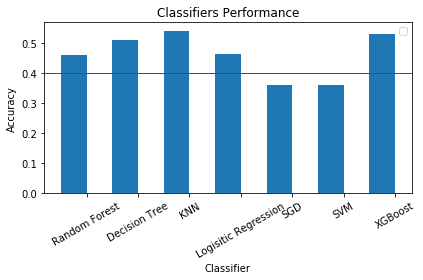

In [61]:
# plot accuracy bar chart

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Random Forest', 'Decision Tree', 'KNN', 'Logisitic Regression', 'SGD', 'SVM', 'XGBoost']
#accuracy = [0.839474	, 0.999123, 0.836842, 1.000000, 0.871053,0.871053	,0.998246	]
accuracy = result['Accuracy'] 

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation = 30)
ax.set_title('Classifiers Performance')
ax.legend()
plt.axhline(y=0.4,linewidth=1, color='r')

fig.tight_layout()

plt.show()